### Part 1 ‐ Exploratory data analysis
    

The goal of this section is to collect a count of user logins for 15 minute intervals. 

<b>Problem Statement:</b> <br>
I will visualize and communicate user's demand by using time series in 15 minute intervals to uncover cycles and/or other patterns of relevant features.

In [1]:
# import libraries
import pandas as pd

In [2]:
## import the data into a pandas dataframe
logins_df = pd.read_json('./logins.json')
logins_df.sort_values('login_time').head()

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [3]:
# Check how many rows and columns
logins_df.shape

(93142, 1)

In [4]:
## convert login_time from str to datetime
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

## check for dtypes
logins_df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
## Create the 'counts' column 
logins_df['counts'] = logins_df.login_time.apply(lambda x: 1)

## sum the counts by 15 minute intervals and save it to a variable called counts_df
counts_df = logins_df.resample('15T', on='login_time').sum()

#### Visualization

The problem now is that the data is so vast that visualizing the 4 months in 15 minute intervals results in a lot of gibberish. 

So, the challenge is to explore the data and sift it down to manageable and visual data that everyone can interpret. 

In [6]:
## import helpful libraries
import seaborn as sns
import matplotlib.pyplot as plt

Let's group by each 15 min interval and sum each.

<AxesSubplot:title={'center':'Counts Per 15 Min Interval'}, ylabel='counts'>

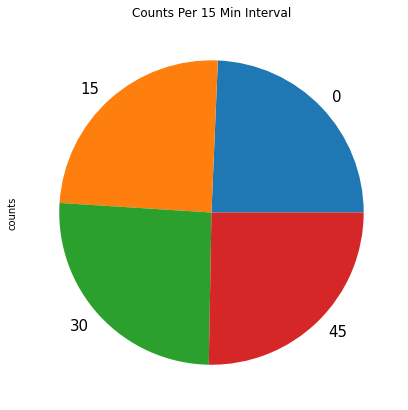

In [7]:
## create a pie chart of counts for 00, 15, 30 and 45 min intervals
counts_df.groupby(counts_df.index.minute).sum().counts.plot(kind='pie', figsize=(7,7), fontsize='15', title='Counts Per 15 Min Interval')

We can visualize that the minute of the hour has no bearing on when users login because each 15 minute interval accounts for roughly 1/4 of the total logins. 

Next, let's look at the number of logins per hour through out the day. 

### Hourly Counts Per Day

<AxesSubplot:title={'center':'Hourly Counts Per Day'}, xlabel='login_time'>

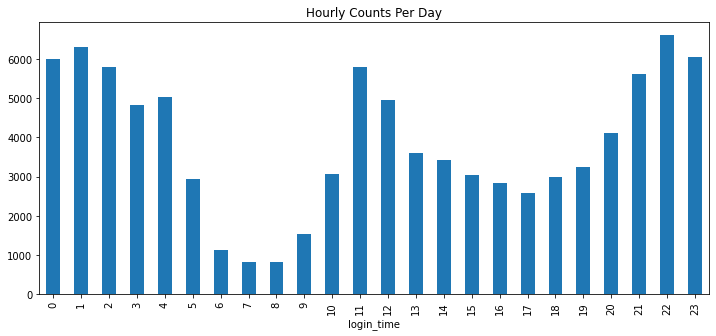

In [8]:
## visualize the counts per day when aggregated for all 4 months
counts_df.groupby(counts_df.index.hour).sum().counts.plot(kind='bar', figsize=(12,5), title='Hourly Counts Per Day')

Looks like there are two peak time period for users to login: 11:00 to 12:00; 21:00 to 02:00.

### Monthly Counts Per Day

<AxesSubplot:title={'center':'Hourly Counts Per Day'}, xlabel='login_time,login_time'>

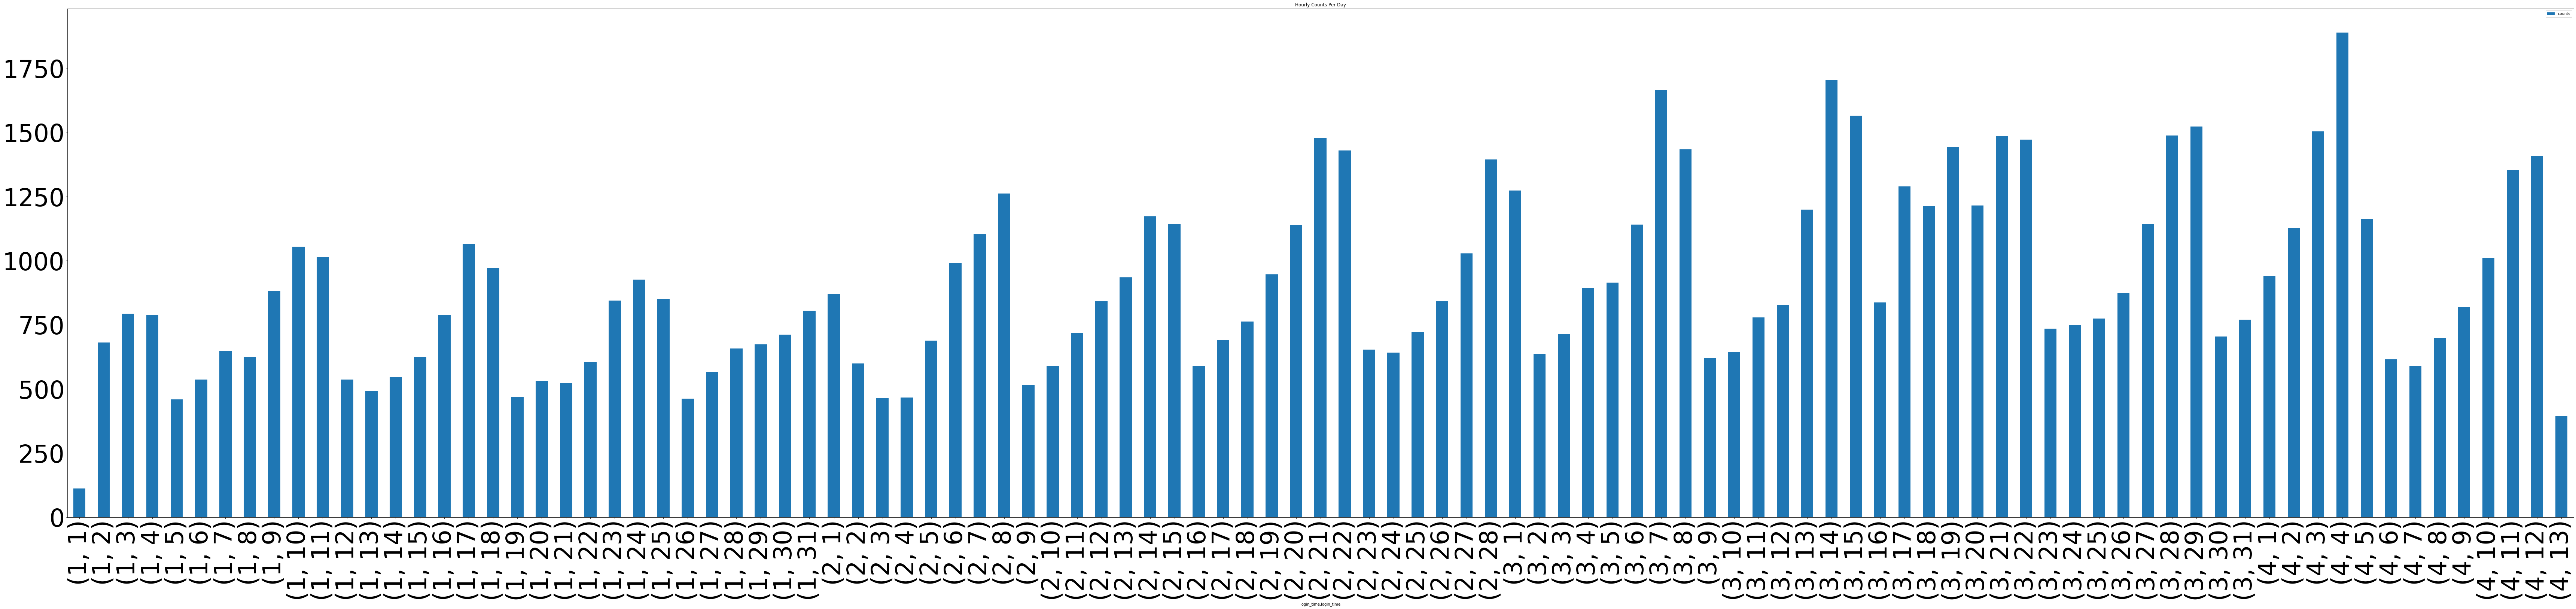

In [9]:
## Look for weekly trends in the data
counts_df.groupby([counts_df.index.month,counts_df.index.day]).sum().plot(kind='bar', figsize=(120,25), title='Hourly Counts Per Day', fontsize=65)

NOTE: After 15 minutes of trying to use seaborn to plot the above chart with the days of week as the hue to no avail, I will just write about my intentions to save time (in some cases it may be apropriate to ask others how to solve this and spend a some more time on it, but this is not one of those cases). Using hue to identify the days of week vs the weekend would give us more insight into how to better serve our users. 

Let's next check for any seasonality by month. The data is from Jan to April only.

### Counts Per Month

<AxesSubplot:title={'center':'Counts Per Month'}, xlabel='login_time'>

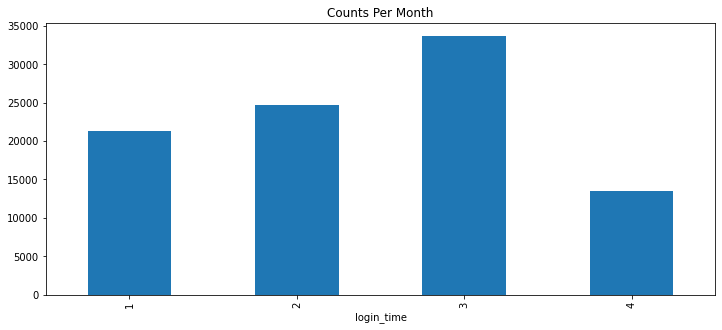

In [10]:
counts_df.groupby(counts_df.index.month).sum().counts.plot(kind='bar', figsize=(12,5), title='Counts Per Month')

The above chart suggests that if we collect more data from other months then we would see some fluctuations in user logins by month. So far, March is the busiest month. 

### Part 2 - Experiment and metrics design

1. The best variable to test in this case would be something like number of transports per driver in each city. I would choose this type of metric so that I can compare the metric before reimbursments are offered with after reimbursments.  

2. First, the business problem needs to be more defined and outlined to create an appropriate experiment. (for example, are there not enough drivers to service the user's demand? If that were the case, then we could identify the times with most demand, make the change to the toll bridge and then measure the highest demand times again.) It seems that the question is will offering reimbursments significantly change the number of driver's serving both cities.

Null hypothesis: There will be no change in driver partners serving both cities once the reimbursements are offered to driver's on the toll road. 
Alternative hypothesis: Offering a reimbursement to driver's will significantly increase the number of driver's serving both cities as more driver's will cross bridge.

I will use a t-test to compare the average number of drivers serving both cities before and after reimbursments go into effect. 

A p-value of more than 0.05 will be necessary to show significant changes.

### Part 3 - Predictive Modeling

In [11]:
import pandas as pd
import numpy as np



In [12]:
df = pd.read_json('./ultimate_data_challenge.json')

In [13]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

### Create 'retained' column

In [15]:
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [16]:
df['last_trip_days_ago'] = df.last_trip_date-df.signup_date

In [17]:
df['last_trip_days_ago'] = df.last_trip_days_ago.apply(lambda x: pd.to_numeric(x.days))

In [18]:
df['retained'] = df.last_trip_days_ago <=30

In [19]:
df.head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_days_ago,retained
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143,False
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96,False
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,True


#### Count Plot for Number of Retained Users

<AxesSubplot:xlabel='retained', ylabel='count'>

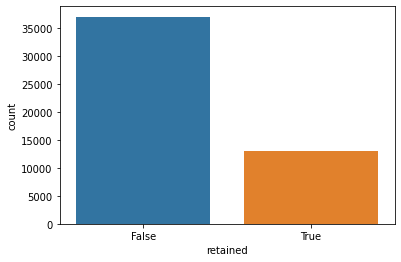

In [20]:
sns.countplot(x="retained", data=df)

There are more than double the number of non-retained users than retained users. This makes our dataset slightly imbalanced and is important to take into account when building a model. 

#### Surge Multiplier

Find if presence of surge multiplier impacts user's retained status

In [21]:
df['surge_bool'] = df.surge_pct.apply(lambda x: x==0)

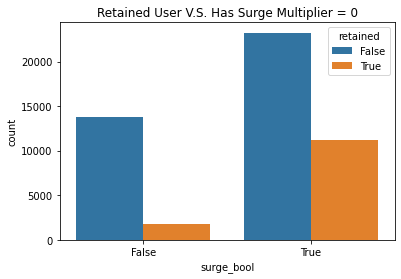

In [22]:
sns.countplot(x='surge_bool', hue='retained', data=df)
hide = plt.title('Retained User V.S. Has Surge Multiplier = 0')

It appears that more users have an average surge multiplier percentage  greater than 0. Also, users are less likely to be considered retained if they do not have a surge multiplier percentage greater than 0.

#### Does average distance matter?

Visualize retained users by average distance binned every 0.025 percentile

In [23]:
## define the labels for each bin by percentiles

n = 0
def percen(bins):
    labels = list()
    n=0
    for x in range(0,bins):
        n+=0.025
        labels.append(round(n,3))
    return labels


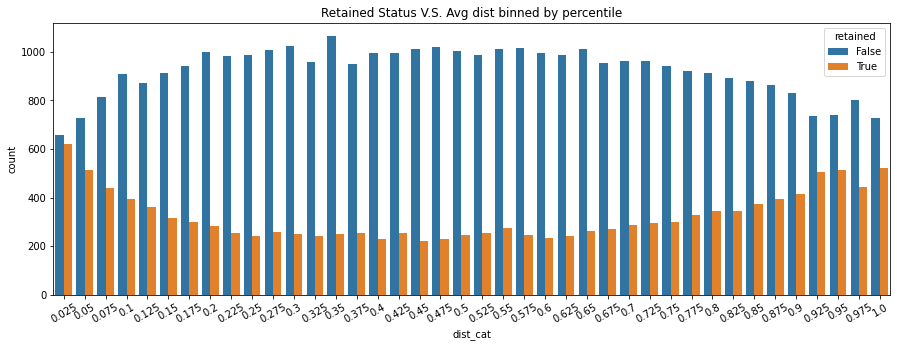

In [24]:

labels = percen(40)

df['dist_cat'] = pd.qcut(df.avg_dist, q=40, labels=labels)


plt.figure(figsize=(15,5))
g=sns.countplot(x='dist_cat', hue="retained", data=df)
hide = g.set_xticklabels(rotation=30, labels=labels)
hidetoo = g.set_title('Retained Status V.S. Avg dist binned by percentile')

Seeing this count plot shows that the closer or farther a user travels on average has a relationship with the likelihood of being a retained user. Those that either have short or far averages are mroe likely to be be considered retained. 

### Check for Null Values

In [25]:
df.isna().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
last_trip_days_ago        False
retained                  False
surge_bool                False
dist_cat                  False
dtype: bool

It is worth noting before we fill the null data that sometimes a lack of data can indicate a pattern or information that is important to capture. 

#### Fill Null Values

In [26]:
filled = df.fillna(method='ffill')

#### Dummy Variables

In [47]:
## Why did my feature engineering result in worse predictive power?

dummy = pd.get_dummies(filled.drop(columns=["surge_bool","dist_cat"]))

In [51]:
dummy.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'last_trip_days_ago', 'retained',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [48]:

for t in dummy.columns:
    if str(dummy[t].dtype)== 'datetime64[ns]':
        dummy.drop(columns=t, inplace=True)

#### Test Train Split

In [50]:
from sklearn.model_selection import train_test_split

y = dummy.retained.values
X = dummy.drop(columns="retained")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0)

logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9980666666666667

#### Log Reg Metrics

(0.9980690372720722, 0.9980666666666667, 0.9980673867934352, None)


<AxesSubplot:>

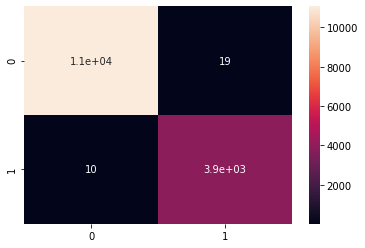

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

y_pred = logreg_pred

print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

#### Support Vector Machine

In [65]:
from sklearn.svm import SVC

model = SVC(gamma='auto')
model.fit(X_train, y_train)
svm_pred = model.predict(X_test)
model.score(X_test, y_test)

0.9882

0.9972 with ["surge_bool","dist_cat"] included.

#### SVM Metrics

(0.988385307426138, 0.9882, 0.9881099154982285, None)


<AxesSubplot:>

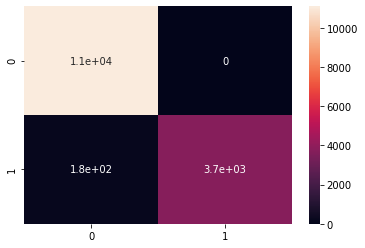

In [66]:
y_pred = svm_pred

print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

#### Multi Layer Perceptron

In [54]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
nn_pred = nn.predict(X_test)
nn.score(X_test, y_test)

0.999

0.9989 with ["surge_bool","dist_cat"] included.

#### MLP Metrics

(0.9990000944385521, 0.999, 0.9990000414601852, None)


<AxesSubplot:>

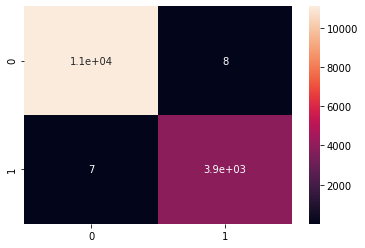

In [67]:
y_pred = nn_pred

print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)